# Project1 - Crash Data Montgomery County, MD

By: Mathias Lund Ahrn & Heidy Togliatti


In this project we will explore vehicle crash data from Montgomery County in Maryland. The data is collected from the Automated Crash Report System of the Maryland State Police. 

#### Our goals
- Explore the relation between:
    - the vehicle year and the type of car accident it was involved in 
    - the speed limit compared to the various collision types and vehicle year
- look for trends between car accidennts in specific days and months compared annually 
  
  
  

### About the dataset
**Name**: Crash Reporting - Drivers Data

**State**: Maryland, MD

**County**: Montgomery

**Last updated**: October 10th 2019

**Date created**: Septemeber 19th 2017

**Dataset Owner**: MCG ESB Service

Data acquired October 15th 2019, hosted on [GitHub](https://raw.githubusercontent.com/CruddyShad0w/CST-383-CrashData/master/Crash_Reporting_-_Drivers_Data.csv) by [Kyle Hays](https://github.com/CruddyShad0w/CST-383-CrashData/).


### Sneakpeak of the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from matplotlib import rcParams
import seaborn as sns
sns.set()
rcParams['figure.figsize'] = 8,6
sns.set_context('talk')

Firstly, converting Crash Date/Time into pandas datetime and set it as index. This is useful for later operations on the data.

In [2]:
url = "https://raw.githubusercontent.com/CruddyShad0w/CST-383-CrashData/master/Crash_Reporting_-_Drivers_Data.csv"

df = pd.read_csv(url)

df.set_index(pd.to_datetime(df['Crash Date/Time']), inplace=True)
df.sort_index(ascending=True, inplace=True)

df.info()

/Users/certinax/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100148 entries, 2015-01-01 00:30:00 to 2019-10-09 20:30:00
Data columns (total 43 columns):
Report Number                     100148 non-null object
Local Case Number                 100148 non-null object
Agency Name                       100148 non-null object
ACRS Report Type                  100148 non-null object
Crash Date/Time                   100148 non-null object
Route Type                        90559 non-null object
Road Name                         91015 non-null object
Cross-Street Type                 90549 non-null object
Cross-Street Name                 91011 non-null object
Off-Road Description              9132 non-null object
Municipality                      10943 non-null object
Related Non-Motorist              3028 non-null object
Collision Type                    99813 non-null object
Weather                           92279 non-null object
Surface Condition                 88280 non-null object
Light       

##### Quick Facts:
- Number of rows: 100 148
- Number of columns: 43
- Each row is a driver

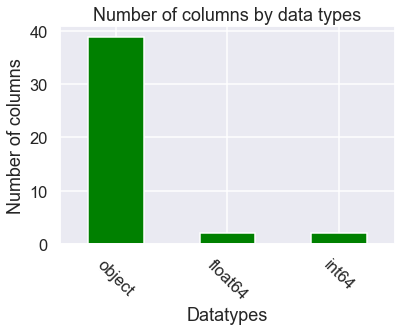

In [3]:
barplot = df.dtypes.value_counts().plot.bar(color="green");
plt.title("Number of columns by data types")
plt.xlabel("Datatypes")
plt.ylabel("Number of columns")
plt.xticks(rotation=-45)
plt.show(barplot)

In [4]:
df.describe().round()

,Speed Limit,Vehicle Year,Latitude,Longitude
count,100148.0,100148.0,100148.0,100148.0
mean,33.0,1970.0,39.0,-77.0
std,11.0,331.0,0.0,0.0
min,0.0,0.0,38.0,-79.0
25%,30.0,2004.0,39.0,-77.0
50%,35.0,2009.0,39.0,-77.0
75%,40.0,2014.0,39.0,-77.0
max,70.0,9999.0,40.0,-76.0


Further investigation of the numeric columns shows weird data. We have minimum and maximum values for *Vehicle Year* that does not make sense. Below is a distribution of all the reported vehicles with 

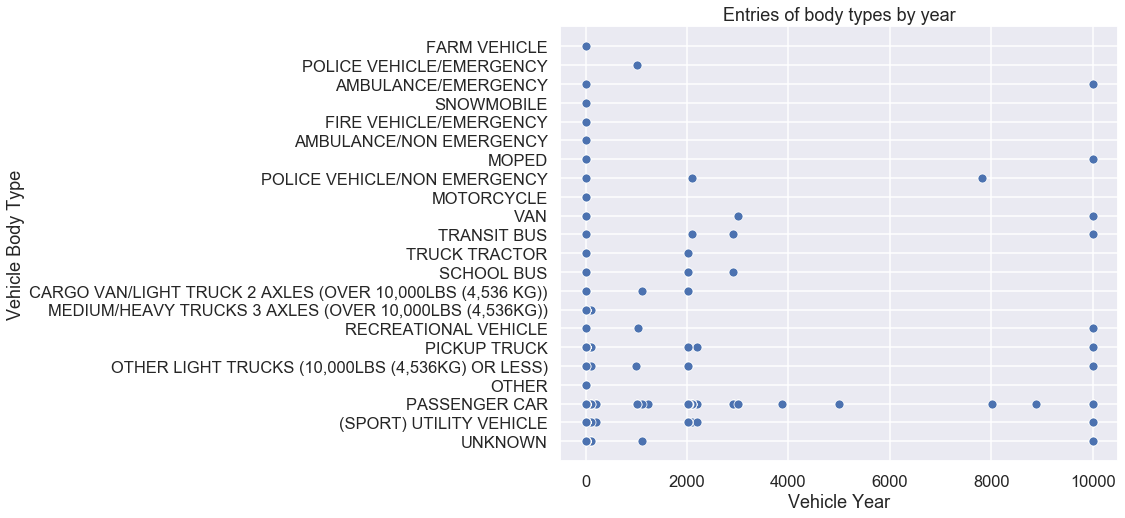

In [5]:
data = df[(df["Vehicle Year"] > 2019) | (df["Vehicle Year"] < 1900)]
plt.figure(figsize=(10,8))
gg = sns.scatterplot(x=data["Vehicle Year"], y=data["Vehicle Body Type"]);
plt.title("Entries of body types by year")
plt.show(gg)

# Data exploration

The scatterplot above doesn't neccessarily tell too much, other than there are several vehicles registered with a model year from 0 to above 2020. To make this more clear, we divide the year range into three reasonable ranges, 0-1899, 1900-2020 and 2021+. When we plot this, we see that most of the reports have reasonable model years, but a lot of the reports have model year 0. This will be a starting point in cleaning the data

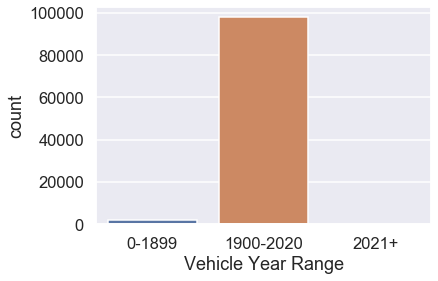

In [6]:
bins = [-1, 1899, 2020, np.inf]
names = ['0-1899', '1900-2020', '2021+']

df['Vehicle Year Range'] = pd.cut(df['Vehicle Year'], bins, labels=names)
data = df["Vehicle Year Range"].value_counts().sort_index()
sns.countplot(df["Vehicle Year Range"]);

#### Number of entries

Each row is represented as a driver. At first glance, it might seem that each entry represents a unique accident. When counting the *Report Number* series, there are clearly several entries with the same Report Number. 

In [7]:
print(df["Report Number"].value_counts().head(3))

MCP12130045    9
MCP2667000H    8
MCP9130001S    7
Name: Report Number, dtype: int64


#### Number of entries with duplicated report numbers:

In [8]:
print(df["Report Number"].value_counts().value_counts().sort_index())

1    17309
2    33578
3     4064
4      689
5      112
6       17
7        8
8        1
9        1
Name: Report Number, dtype: int64


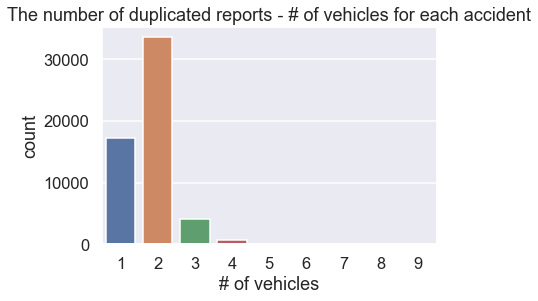

In [9]:
reports = df["Report Number"].value_counts()
reportplot = sns.countplot(reports)
plt.title("The number of duplicated reports - # of vehicles for each accident")
plt.xlabel("# of vehicles")
plt.show(reportplot)

With further investigation of the data, one can see that there are different *Vehicle ID's* for all entries sharing the same *Report Number*. With this information in mind, the plot above tells that most of the accidents involve two vehicles. 

### Data Cleaning

Columns of interest; [Driver at Fault], [Vehicle Year], [Speed Limi], [Vehicle Body Type], [Collision Type], [ACRS Report type], [Driver Substance Abuse], [Report Number]

Clearing all data that will not be used for this report.

In [10]:
df.drop(columns=['Local Case Number', 'Agency Name',
       'Crash Date/Time', 'Route Type', 'Road Name', 'Cross-Street Type',
       'Cross-Street Name', 'Off-Road Description', 'Municipality',
       'Related Non-Motorist', 'Weather',
       'Surface Condition', 'Light', 'Traffic Control', 'Non-Motorist Substance Abuse', 'Person ID',
      'Injury Severity', 'Circumstance',
       'Driver Distracted By', 'Drivers License State', 'Vehicle ID',
       'Vehicle Damage Extent', 'Vehicle First Impact Location',
       'Vehicle Second Impact Location',
       'Vehicle Movement', 'Vehicle Continuing Dir', 'Vehicle Going Dir',
        'Driverless Vehicle', 'Parked Vehicle',
       'Vehicle Make', 'Vehicle Model', 'Equipment Problems', 'Latitude',
       'Longitude', 'Location', "Vehicle Year Range"], inplace=True)

#### Vehicle Year

Focuses on 1980-present as there are few values below this year that are valid. The plot below shows the distribution of cars based on year of make.

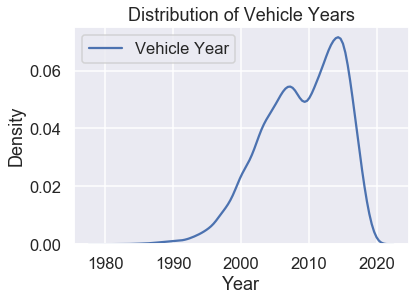

In [11]:
df = df[(df["Vehicle Year"] >= 1980) & (df["Vehicle Year"] <= 2020)]
yearDist = sns.kdeplot(df["Vehicle Year"], bw=.8);
plt.title("Distribution of Vehicle Years")
plt.xlabel("Year")
plt.ylabel("Density")
plt.show(yearDist)

#### Driver Substance Abuse

Looking at the values for driver substance abuse there are these categories. And there are a number of N/A and *unkown* values that will be dropped. 

In [12]:
df["Driver Substance Abuse"].value_counts()

NONE DETECTED                 71675
UNKNOWN                        4470
ALCOHOL PRESENT                2325
ALCOHOL CONTRIBUTED             859
ILLEGAL DRUG PRESENT            171
MEDICATION PRESENT               71
COMBINED SUBSTANCE PRESENT       46
ILLEGAL DRUG CONTRIBUTED         45
MEDICATION CONTRIBUTED           42
OTHER                            32
COMBINATION CONTRIBUTED          24
Name: Driver Substance Abuse, dtype: int64

In [13]:
substanceMask = ~df["Driver Substance Abuse"].isin(["UNKNOWN", np.nan])
df = df[substanceMask]

#### Vehicle Body Type

There is a small number of N/A and *UNKNOWN* values in this column that will be removed.

Number of N/A's:

In [14]:
print(df["Vehicle Body Type"].isna().sum())

64


Number of 'UNKNOWN':

In [15]:
print(df["Vehicle Body Type"].isin(["UNKNOWN"]).sum())

42


In [16]:
bodyTypeMask = ~df["Vehicle Body Type"].isin(["UNKNOWN", np.nan])
df = df[bodyTypeMask]

In [17]:
driverAtFaultMask = ~df["Driver At Fault"].isin(["Unknown"])
df = df[driverAtFaultMask]

#### Collision Type 

In the *Collision Type* column there are unknown and N\A values that will be dropped 

In [18]:
CollisionTypeMask = ~df["Collision Type"].isin(["UNKNOWN", np.nan])
df = df[CollisionTypeMask]

### Questions about the data 

Are older cars more prone to accidents than newer cars?

In [19]:
df.describe().round()

,Speed Limit,Vehicle Year
count,73356.0,73356.0
mean,34.0,2009.0
std,10.0,6.0
min,0.0,1980.0
25%,30.0,2005.0
50%,35.0,2010.0
75%,40.0,2014.0
max,70.0,2020.0


In [20]:
bins = [1979, 1989, 1999, 2009, 2019, 2029]
names = ["80's", "90's", "00's", "10's", "20's"]
df["Decade"] = pd.cut(df["Vehicle Year"], bins, labels=names)

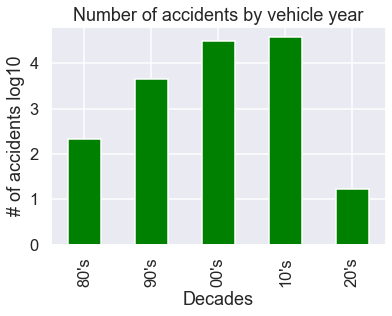

In [21]:
carPlot = df["Decade"].value_counts().sort_index().apply(np.log10).plot.bar(color="green")
plt.title("Number of accidents by vehicle year")
plt.xlabel("Decades")
plt.ylabel("# of accidents log10")
plt.show(carPlot)

This plot shows that there seems to be more accidents for cars in the 2000's and 2010's. However, one thing to keep in mind is that there are a lot more entires in these years than some of the others. 

#### Are older cars responsible for more accidents than newer cars?

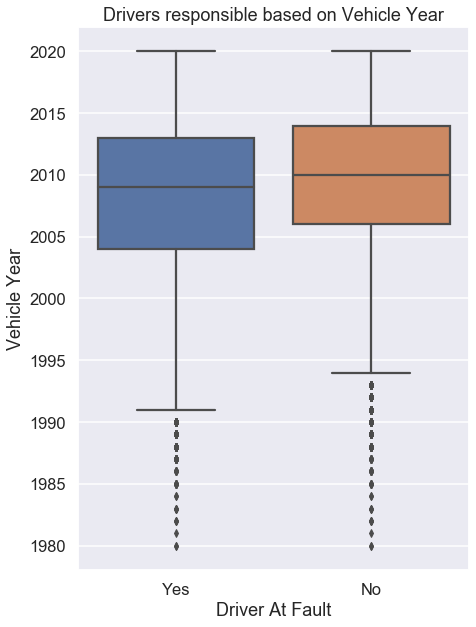

In [22]:
plt.figure(figsize = (7,10))
sns.boxplot(y="Vehicle Year", x="Driver At Fault", data=df);
plt.title("Drivers responsible based on Vehicle Year");

From the graph above it does indeed look like there are more drivers with older cars that are responsible for accidents. However the difference is not very significant. But the median for drivers responsible is definitely at a lower vehicle year.

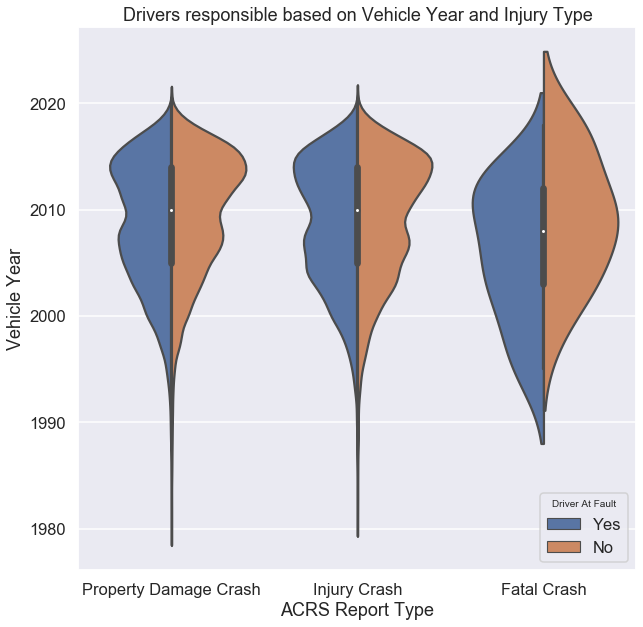

In [23]:
plt.figure(figsize = (10,10))
sns.violinplot(y="Vehicle Year", x="ACRS Report Type", hue="Driver At Fault", split=True, data=df, legend=False);
plt.legend(loc="lower right", title="Driver At Fault")
plt.title("Drivers responsible based on Vehicle Year and Injury Type");

The graph above is showing correlation between drivers at fault, vehicle year, and injury type. It shows the same information as in the previous plot where it seems that there is a marginally bigger probability that a driver at fault will drive an older car. However, in this plot information is displayed about the different injury types and it seems like there is a bigger difference in fatal crashes than in the other two. It is worth noting that we have relatively few values for fatal crashes.

#### Number of accidents during holidays, July 4th and December 24th

In order to deal with specific dates, we are creating a new column with normalized dates- this makes it easier to access specific dates.

In [24]:
df["Normalized date"] = df.index.normalize()

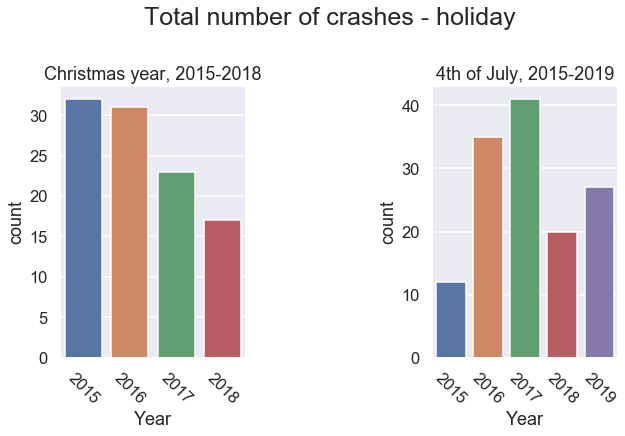

In [25]:
years = df.index.year.unique()

christmas = pd.date_range("2015-12-24", periods=(years.size-1), freq=pd.DateOffset(months=12, day=24))
fourthJuly = pd.date_range("2015-07-04", periods=years.size, freq=pd.DateOffset(months=12, day=4))


christmas_crashes = df[df["Normalized date"].isin(christmas)].drop_duplicates("Report Number")
fourthJuly_crashes = df[df["Normalized date"].isin(fourthJuly)]

christDf = pd.DataFrame(christmas_crashes.groupby("Normalized date").size()).reset_index()
christDf.rename({0:"count"}, axis="columns", inplace=True)

christmas_labels = df["Normalized date"].apply(lambda x: x.strftime("%Y")).unique()
fourthJuly_labels = df["Normalized date"].apply(lambda x: x.strftime("%Y")).unique()
y_pos = np.arange(len(christmas_labels))

fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.countplot(x="Normalized date", data=christmas_crashes, ax=ax[0])
sns.countplot(x="Normalized date", data=fourthJuly_crashes, ax=ax[1])
fig.suptitle("Total number of crashes - holiday", size=25, y=1.1)
ax[0].set_title("Christmas year, 2015-2018")
ax[1].set_title("4th of July, 2015-2019")
plt.subplots_adjust(wspace=1)
ax[0].set_xlabel("Year")
ax[1].set_xlabel("Year")
ax[0].set_xticklabels(christmas_labels, rotation=-45)
ax[1].set_xticklabels(christmas_labels, rotation=-45)
plt.show()

From the bar plot above we can see a trend during Christmas that in more frequent years there have been significantly less car accidents. Whereas, during 4th of July, the numbers skew and there doesn't seem to be a positive trend in terms of number of accidents. 

#### Lets look at the number of crashes each month compared annually

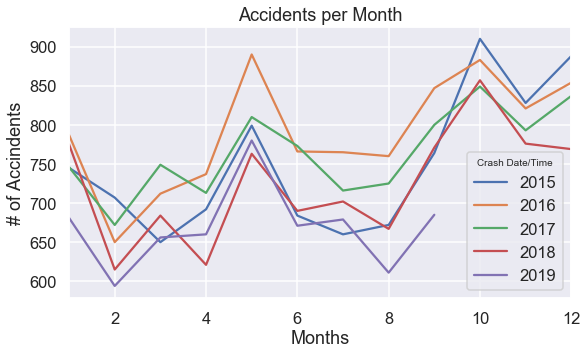

In [26]:
fig, plot = plt.subplots(figsize=(9,5))

collisions = df.drop_duplicates('Report Number')
collisions = collisions["2015":"2019-09-30"]

collisions.groupby([collisions.index.month , collisions.index.year]).count()['Report Number'].unstack().plot(ax=plot)
plt.title('Accidents per Month')
plt.ylabel('# of Accindents')
plt.xlabel('Months')
plt.show()

From the plot above one can see that between 2015-2019 there are significantly more car accidents in May and October and there are less car accidents in February. 

#### Looking at each decade in relation to accident type

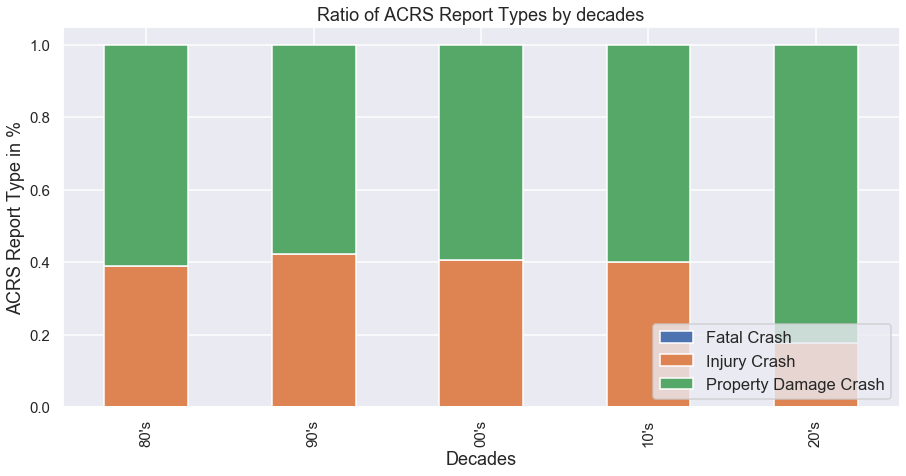

In [27]:
def calcPercent(x):
    return x.groupby("ACRS Report Type").size()/x["ACRS Report Type"].shape[0]

percents = df.groupby("Decade").apply(calcPercent)
crashPercentage = pd.DataFrame(percents).reset_index()

crashPercentage.rename({0:"ReportType.perc"}, axis="columns", inplace=True)

pivot_df = crashPercentage.pivot(index='Decade', columns='ACRS Report Type', values='ReportType.perc').replace(np.nan, 0)
pivot_df.plot.bar(stacked=True, figsize=(15,7));
plt.title("Ratio of ACRS Report Types by decades");
plt.xlabel("Decades");
plt.ylabel("ACRS Report Type in %");
plt.legend(loc="lower right")
plt.xticks(size=15);
plt.yticks(size=15); 

The plot above shows the ratio in terms of types of accidents for each decade. By looking at the plot, there seems to be more property damage than injury accidents no matter the decade. Note: there are so few fatal accidents that they are not even visible in the plot. 

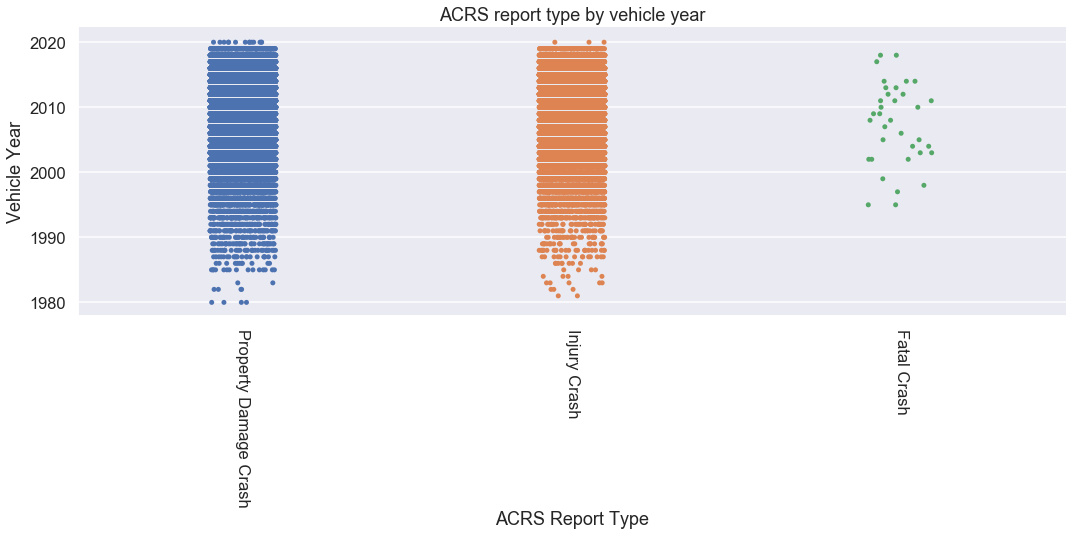

In [28]:
a = sns.catplot(x="ACRS Report Type", y="Vehicle Year", data=df, height=5, aspect=3)
a.set_xticklabels(rotation=-90)
plt.title("ACRS report type by vehicle year")
plt.show(a)

The plot above shows the number of accident types in terms of vehicle year. From the plot one can see there are a few fatal accidents that have occured throughout the decades. This also reflects the results from the previous plot.

### Conclusion

#### What we have learned:
  - Having a dataset heavily loaded with categorical data makes it great to visualize counts with different variables and layering categories.
  - Changing even one category is very insightful to see information on different things.



#### Issues/Challenges we experienced: 
  - From the dataset that we have been working with, there have been a couple of challenges on how to deal with missing and bad data. How will the results be affected if we remove x entries for column y. By looking at plots and distribution throughout the project, the distributions seems to keep the same ratios for the data we are looking at.


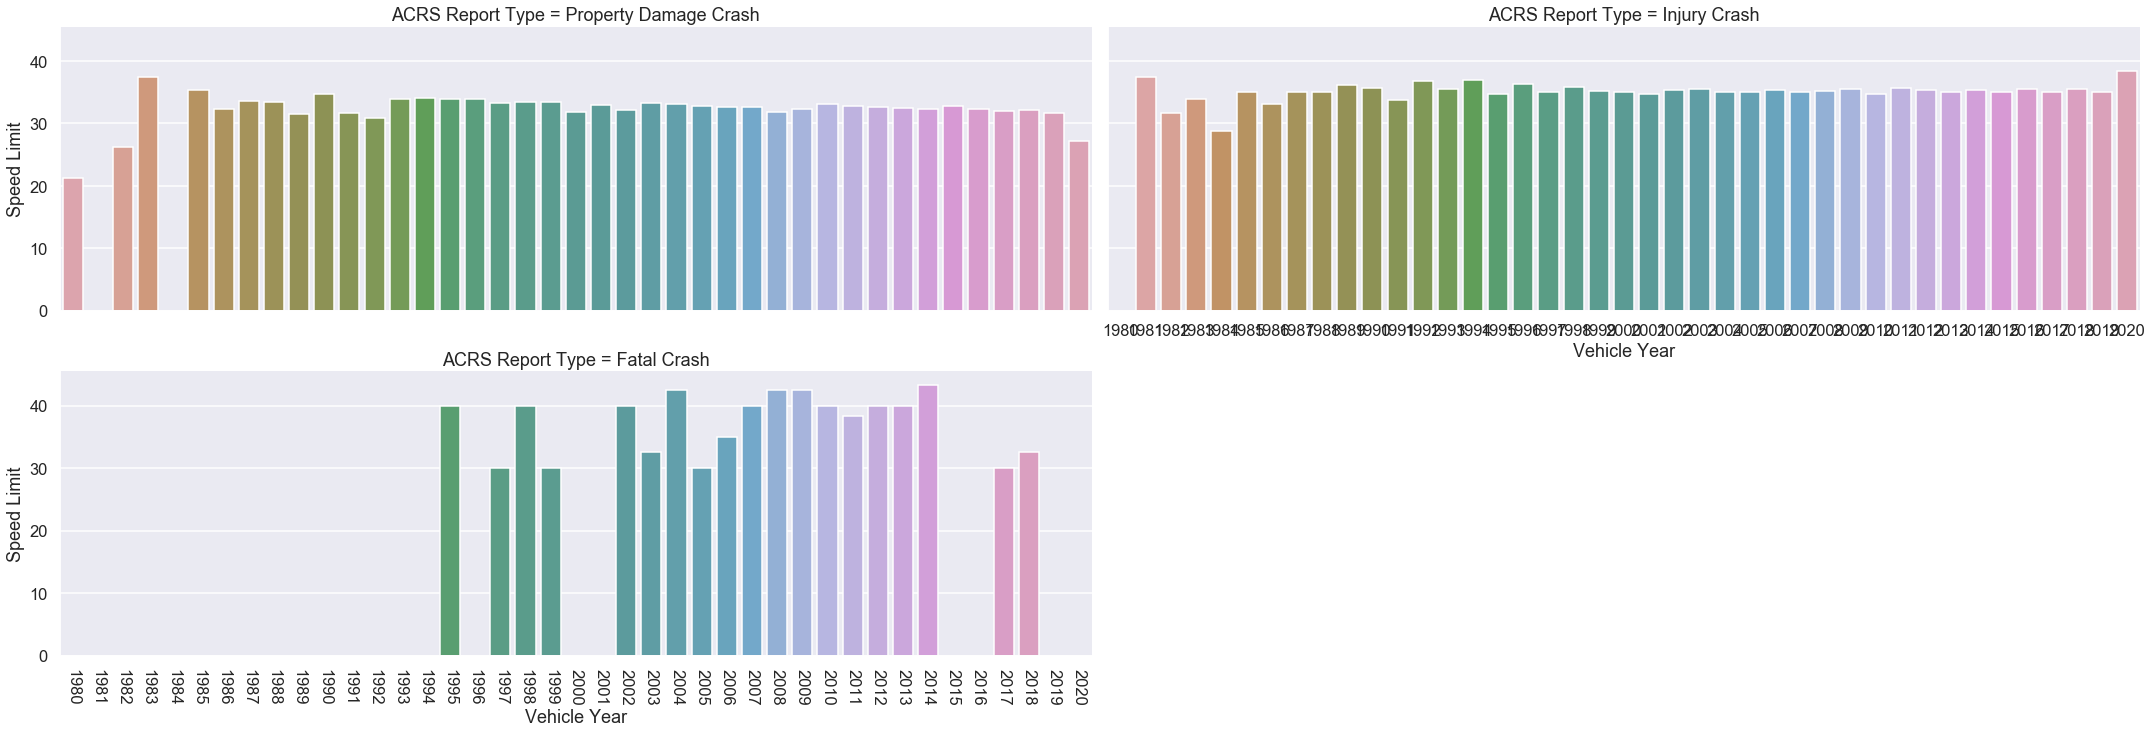

In [41]:
c = sns.catplot(x= "Vehicle Year", y="Speed Limit", col= "ACRS Report Type", data = df, saturation =.5,
               kind = "bar", ci= None, aspect = 3, height = 5, col_wrap=2)
#plt.subplots_adjust(hspace=3)
plt.xticks(rotation=-90)

plt.show(c)